# **Airbnb NYC 2019: Comprehensive Data Analysis and Insights**


## **Introduction**

This project analyzes Airbnb listings dataset for New York City from 2019. The dataset contains detailed information on listings across NYC boroughs, including pricing, availability, room types, host characteristics, reviews, and geographical locations. Understanding these factors provides valuable insights into the NYC Airbnb market which helps hosts optimize their offerings and potential guests to make informed decisions.



**Objective**:
- Analyze how prices differ by borough and room type.

- Analyze listing availability patterns and their relationship with location and room type.

- Understand host behavior, including listing counts and categories.

- Analyze review patterns and their distribution across room types and boroughs.

- Perform statistical tests (ANOVA and Chi-Squared) to validate key differences and associations in the data.

- Provide insights that can help hosts optimize their listings and guests make informed choices.



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick

In [97]:
# Load the dataset
df = pd.read_csv(r'/content/AB_NYC_2019.csv')

In [98]:
print('shape:', df.shape)
df.head(5)

shape: (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

# **Data Cleaning**

In [100]:
# Check missing values
df.isnull().sum()

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


In [101]:
# Handle missing values
df = df.copy()
df['name'].fillna('No Name', inplace=True)
df['host_name'].fillna('No Host Name', inplace=True)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [102]:
# Remove listings with price = 0
df = df[df['price'] > 0]

In [103]:
# Remove extreme outliers in price (above 99.5th percentile)
price_threshold = df['price'].quantile(0.995)
df = df[df['price'] <= price_threshold]

In [104]:
# Convert last_review to datetime
df['last_review'] = pd.to_datetime(df['last_review'])

# **Exploratory Data Analysis**

In [105]:
# Top 10 most frequent neighbourhood + room type combinations
top_neighborhoods = (df.groupby(['neighbourhood', 'room_type']).size().reset_index(name='count').sort_values('count', ascending=False).head(10))
print("\nTop 10 Neighbourhood + Room Type combinations:\n")
print(top_neighborhoods)


Top 10 Neighbourhood + Room Type combinations:

          neighbourhood        room_type  count
31   Bedford-Stuyvesant     Private room   2030
525        Williamsburg     Private room   1994
524        Williamsburg  Entire home/apt   1884
68             Bushwick     Private room   1717
30   Bedford-Stuyvesant  Entire home/apt   1585
234              Harlem     Private room   1571
491     Upper East Side  Entire home/apt   1298
494     Upper West Side  Entire home/apt   1236
236      Hell's Kitchen  Entire home/apt   1181
157        East Village  Entire home/apt   1162


In [106]:
# Top 10 most expensive listings
top_prices = df[['name', 'neighbourhood_group', 'room_type', 'price']].sort_values(by='price', ascending=False).head(10)
print("\nTop 10 Most Expensive Listings:\n")
print(top_prices)


Top 10 Most Expensive Listings:

                                                    name neighbourhood_group  \
24540  Loft-like turn of the century apartment for sh...           Manhattan   
43201    Coming soon: stunning Upper West Side apartment           Manhattan   
3812                               2BD/2BA Manhattan Apt           Manhattan   
3804                  SuperBowl Weekend Rental! 3 BR/1ba           Manhattan   
11394                      Beautiful Brooklyn Brownstone            Brooklyn   
5432                      Brooklyn townhouse for filming            Brooklyn   
22472  New Years EVE in NY! Magnificent Private Penth...              Queens   
39766                                  Ashly’s apartment           Manhattan   
39736  STEPS FROM BALL DROP IN TIME SQR! Sleeps up to 8!           Manhattan   
8530   Luxury 1-Bedroom King Suite with Central Park ...           Manhattan   

             room_type  price  
24540  Entire home/apt   1000  
43201  Entire home/ap

# **Price Distribution Analysis**

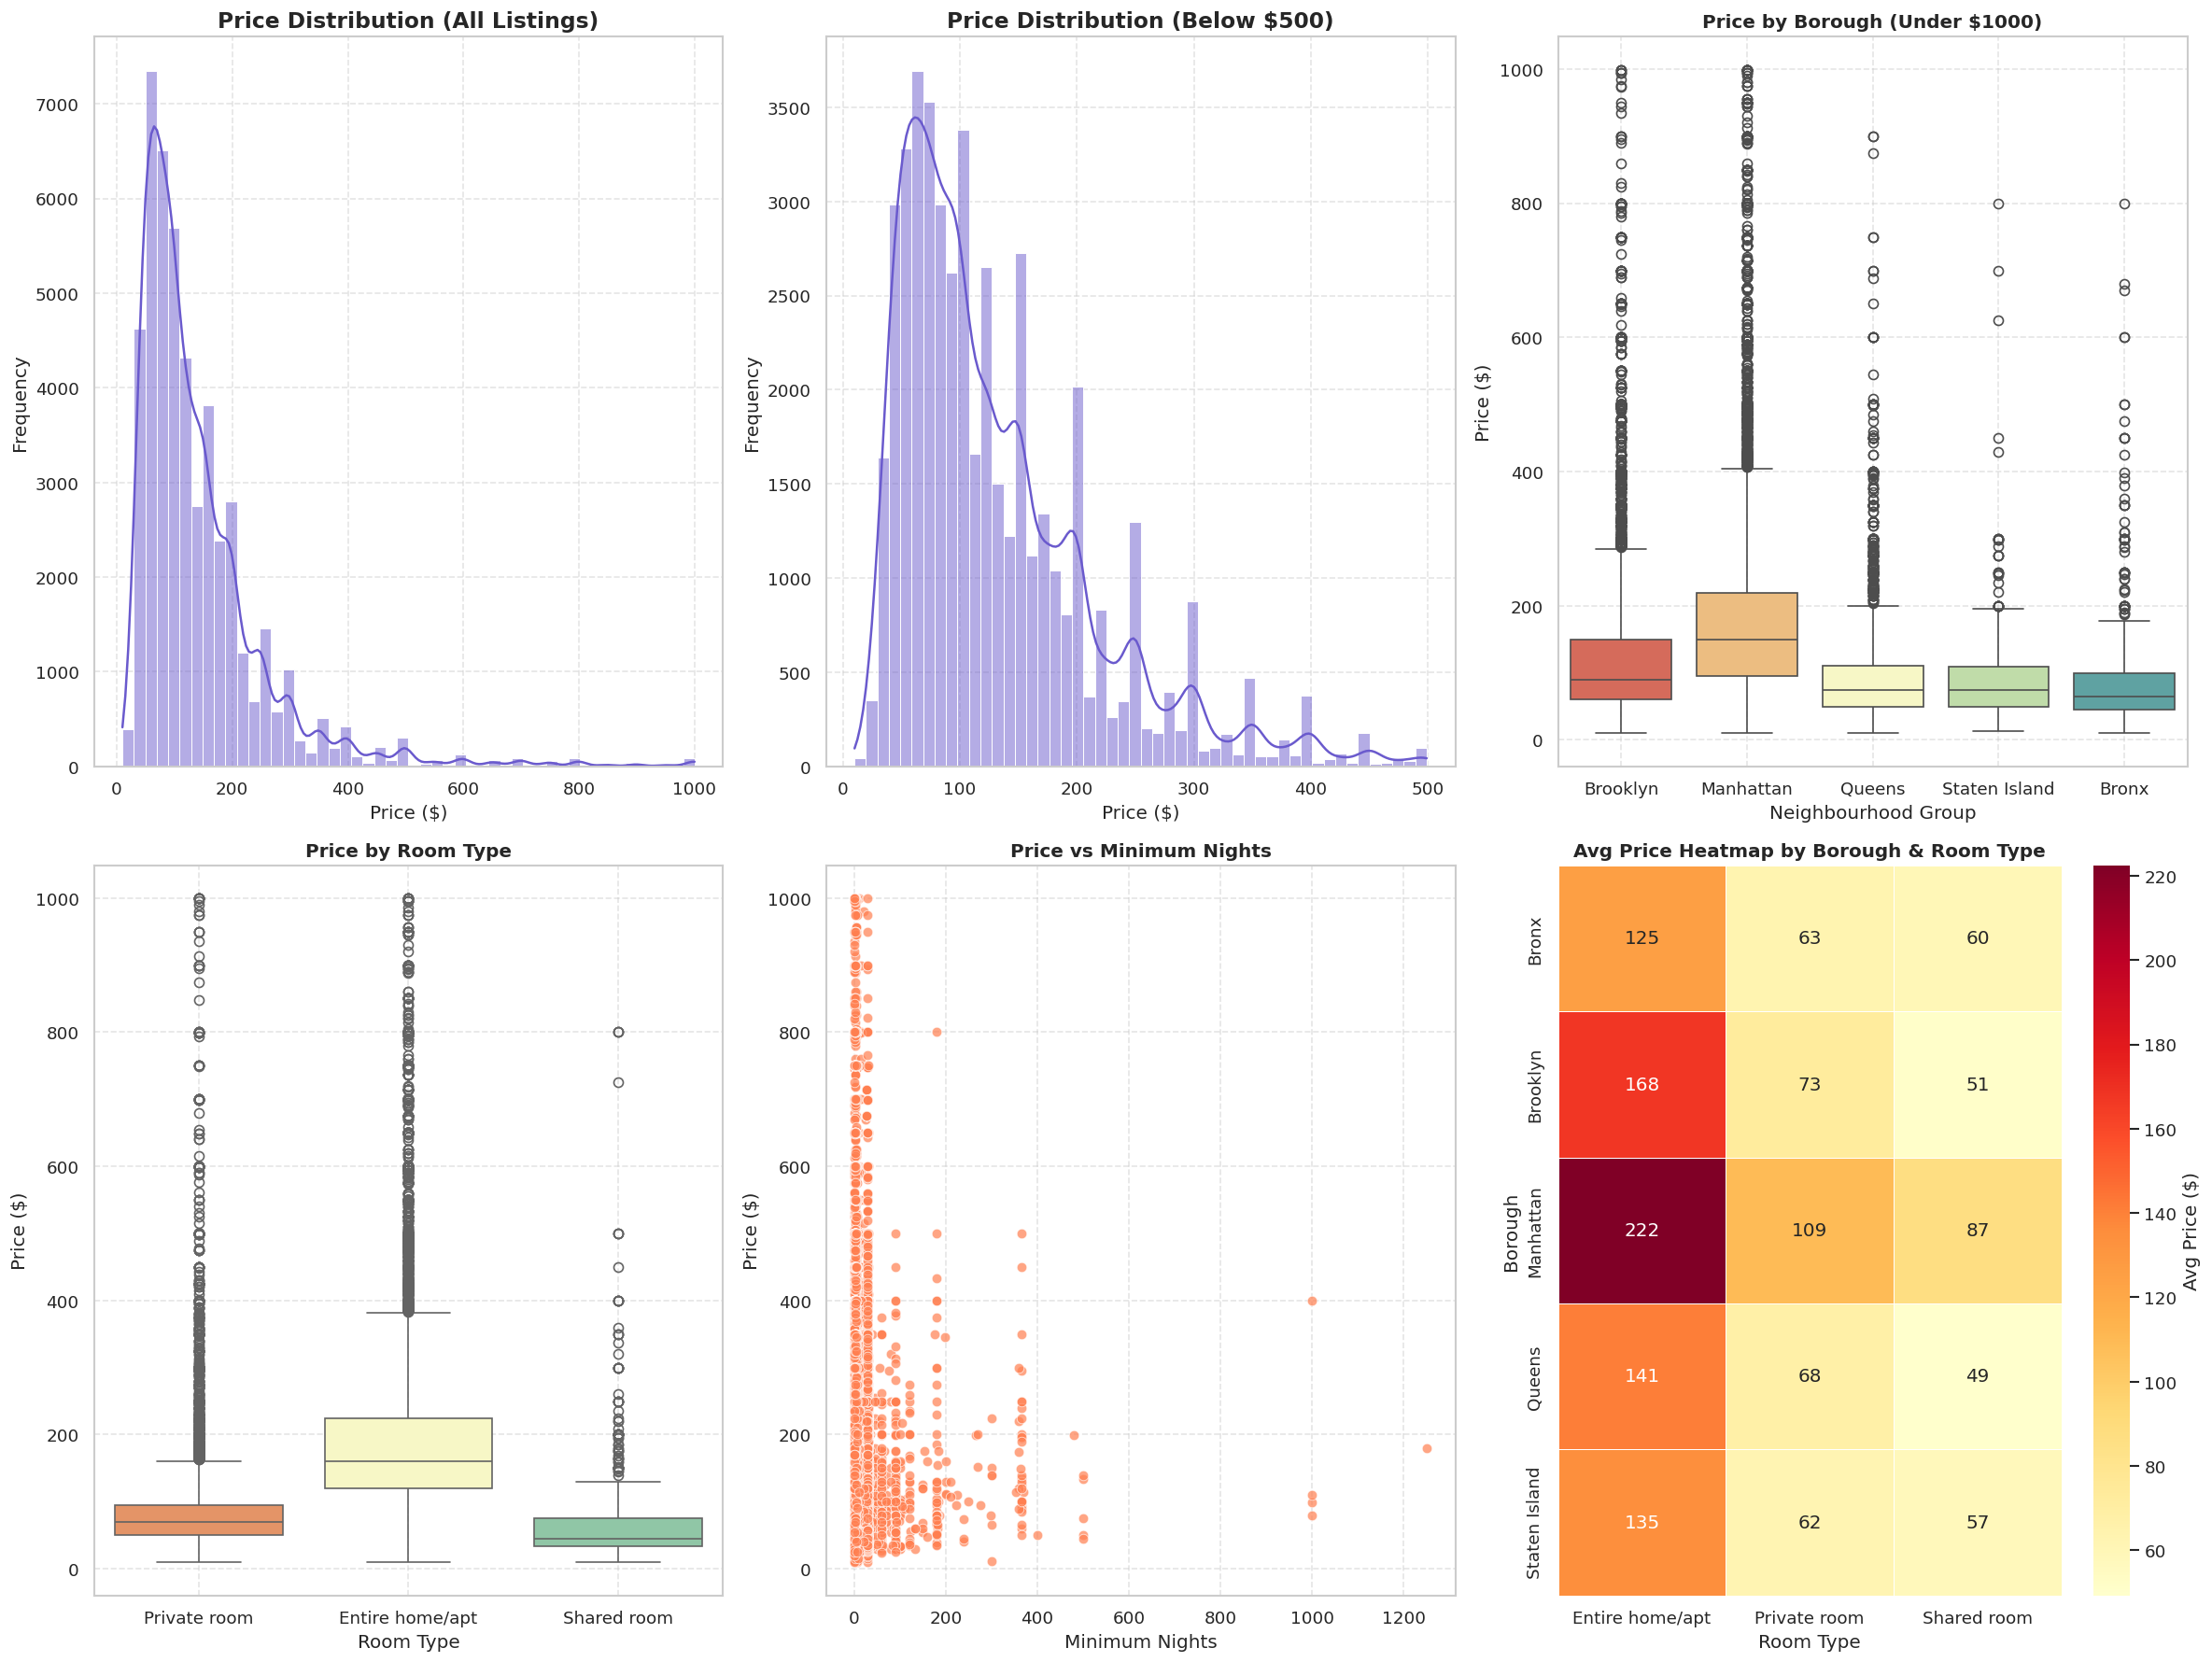

In [192]:
box_palette = 'Spectral'
scatter_color = 'coral'
hist_color = 'slateblue'
heatmap_cmap = 'YlOrRd'

plt.figure(figsize=(20, 15))

# Price Distribution - All Listings
plt.subplot(2, 3, 1)
sns.histplot(data=df, x='price', bins=50, color=hist_color, kde=True)
plt.title('Price Distribution (All Listings)', fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(linestyle='--', alpha=0.5)

# Price Distribution - Under $500
plt.subplot(2, 3, 2)
sns.histplot(data=df[df['price'] < 500], x='price', bins=50, color=hist_color, kde=True)
plt.title('Price Distribution (Below $500)', fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(linestyle='--', alpha=0.5)

# Boxplot - Price by Borough (Under $1000)
plt.subplot(2, 3, 3)
sns.boxplot(data=df[df['price'] < 1000], x='neighbourhood_group', y='price', palette=box_palette)
plt.title('Price by Borough (Under $1000)', fontweight='bold')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Price ($)')
plt.grid(linestyle='--', alpha=0.5)

# Boxplot - Price by Room Type
plt.subplot(2, 3, 4)
sns.boxplot(data=df[df['price'] < 1000], x='room_type', y='price', palette=box_palette)
plt.title('Price by Room Type', fontweight='bold')
plt.xlabel('Room Type')
plt.ylabel('Price ($)')
plt.grid(linestyle='--', alpha=0.5)

# Scatterplot - Price vs Minimum Nights
plt.subplot(2, 3, 5)
sns.scatterplot(data=df[df['price'] < 1000], x='minimum_nights', y='price', alpha=0.7, color=scatter_color, s=40)
plt.title('Price vs Minimum Nights', fontweight='bold')
plt.xlabel('Minimum Nights')
plt.ylabel('Price ($)')
plt.grid(linestyle='--', alpha=0.5)

# Heatmap - Avg Price by Borough and Room Type
plt.subplot(2, 3, 6)
price_pivot = df[df['price'] < 1000].groupby(['neighbourhood_group', 'room_type'])['price'].mean().unstack()
sns.heatmap(price_pivot, annot=True, cmap=heatmap_cmap, fmt='.0f', linewidths=0.5, cbar_kws={'label': 'Avg Price ($)'})
plt.title('Avg Price Heatmap by Borough & Room Type', fontweight='bold')
plt.xlabel('Room Type')
plt.ylabel('Borough')

plt.tight_layout()
plt.show()

In [144]:
print("\n📈 Summary of Listing Prices:")
print(f" - Average price across listings: ${df['price'].mean():,.2f}")
print(f" - Median price : ${df['price'].median():,.2f}")
print(f" - Price variability (standard deviation): ${df['price'].std():,.2f}")
print(f" - Full price range: ${df['price'].min():,.2f} to ${df['price'].max():,.2f}")


📈 Summary of Listing Prices:
 - Average price across listings: $141.31
 - Median price : $105.00
 - Price variability (standard deviation): $116.73
 - Full price range: $10.00 to $1,000.00


# **Geographical analysis**

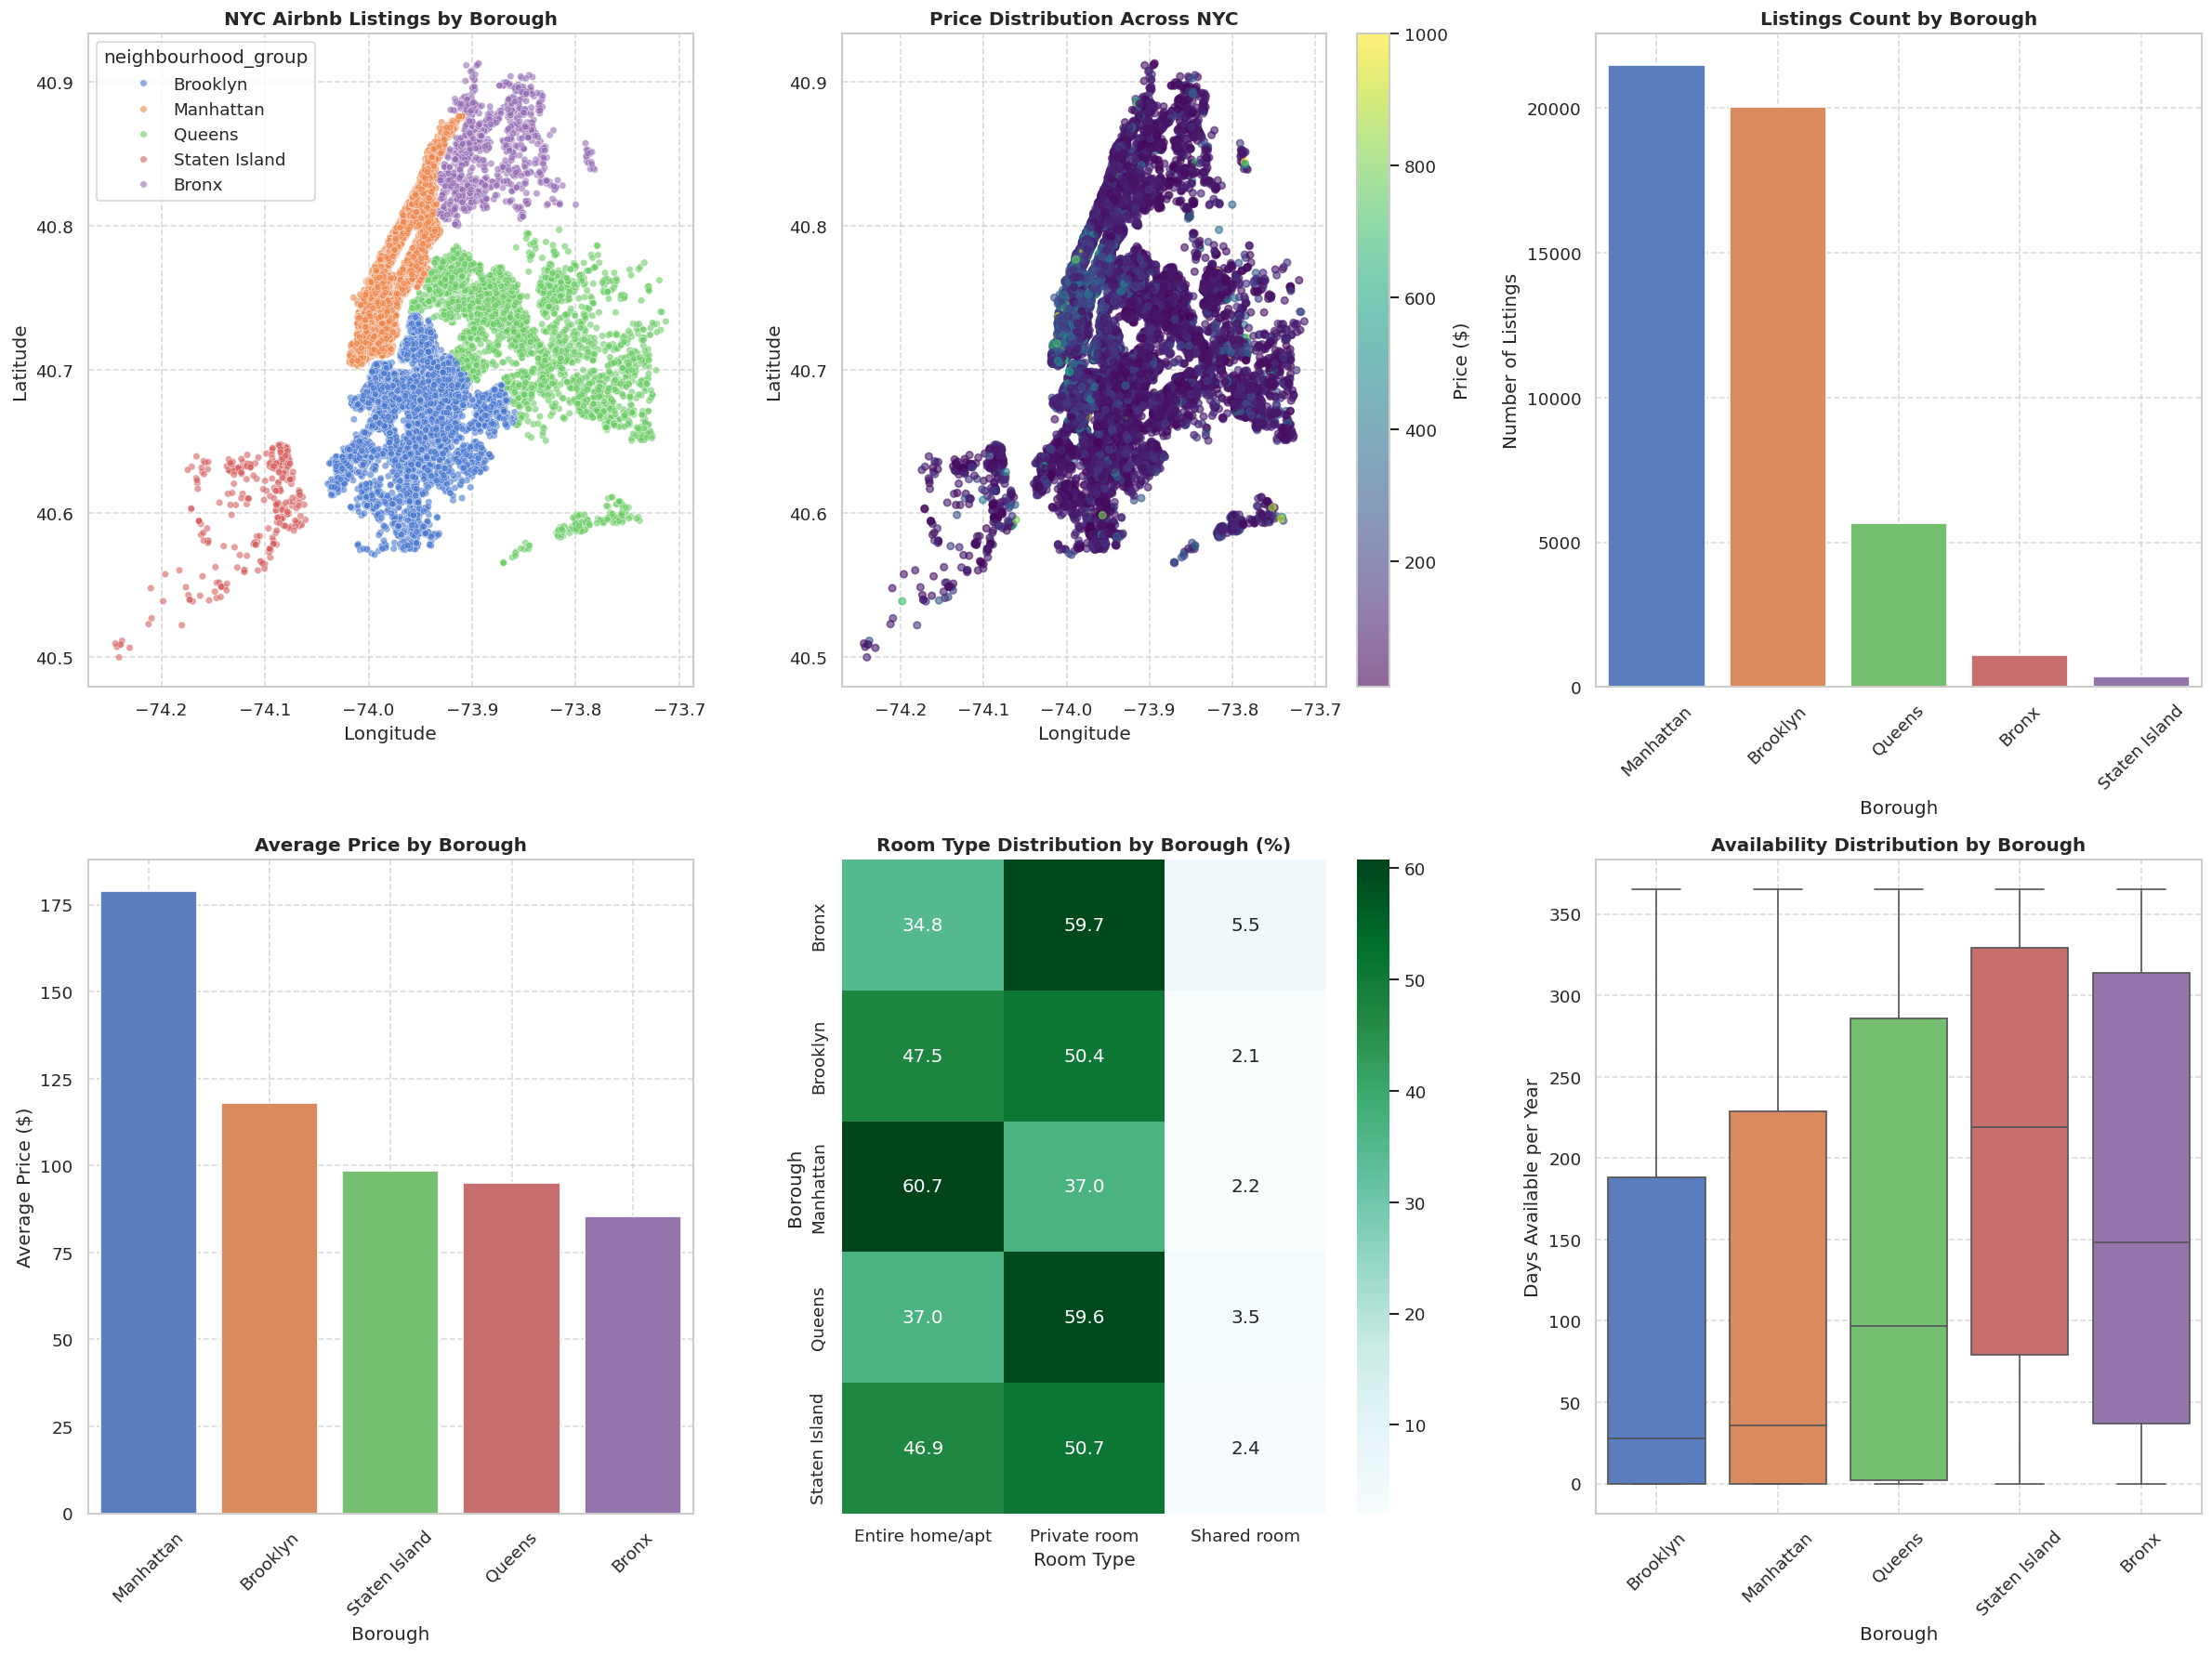

In [162]:
plt.figure(figsize=(20, 15))
bar_palette = 'muted'
box_palette = 'muted'

# Subplot 1: Scatter plot of all listings
plt.subplot(2, 3, 1)
sns.scatterplot(data=df, x='longitude', y='latitude',
                hue='neighbourhood_group', alpha=0.6, s=20, palette=bar_palette)
plt.title('NYC Airbnb Listings by Borough', fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(linestyle='--',alpha=0.7)

# Subplot 2: Price heatmap by location
plt.subplot(2, 3, 2)
plt.scatter(df['longitude'], df['latitude'], c=df['price'],
            cmap='viridis', alpha=0.6, s=20)
plt.colorbar(label='Price ($)')
plt.title('Price Distribution Across NYC', fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(linestyle='--',alpha=0.7)

# Subplot 3: Listings count by neighbourhood group
plt.subplot(2, 3, 3)
borough_counts = df['neighbourhood_group'].value_counts()
sns.barplot(x=borough_counts.index, y=borough_counts.values, palette=bar_palette)
plt.title('Listings Count by Borough', fontweight='bold')
plt.xlabel('Borough')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.grid(linestyle='--',alpha=0.7)

# Subplot 4: Average price by neighbourhood group
plt.subplot(2, 3, 4)
avg_price = df.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price.index, y=avg_price.values, palette=bar_palette)
plt.title('Average Price by Borough', fontweight='bold')
plt.xlabel('Borough')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.grid(linestyle='--',alpha=0.7)

# Subplot 5: Room type distribution by borough (heatmap)
plt.subplot(2, 3, 5)
room_borough = pd.crosstab(df['neighbourhood_group'], df['room_type'])
room_borough_pct = room_borough.div(room_borough.sum(axis=1), axis=0) * 100
sns.heatmap(room_borough_pct, annot=True, cmap='BuGn', fmt='.1f')
plt.title('Room Type Distribution by Borough (%)', fontweight='bold')
plt.xlabel('Room Type')
plt.ylabel('Borough')
plt.grid(linestyle='--',alpha=0.7)

# Subplot 6: Availability by borough (boxplot)
plt.subplot(2, 3, 6)
sns.boxplot(data=df, x='neighbourhood_group', y='availability_365', palette=box_palette)
plt.title('Availability Distribution by Borough', fontweight='bold')
plt.xlabel('Borough')
plt.ylabel('Days Available per Year')
plt.xticks(rotation=45)
plt.grid(linestyle='--',alpha=0.7)

plt.tight_layout()
plt.show()

# **Host Analysis**

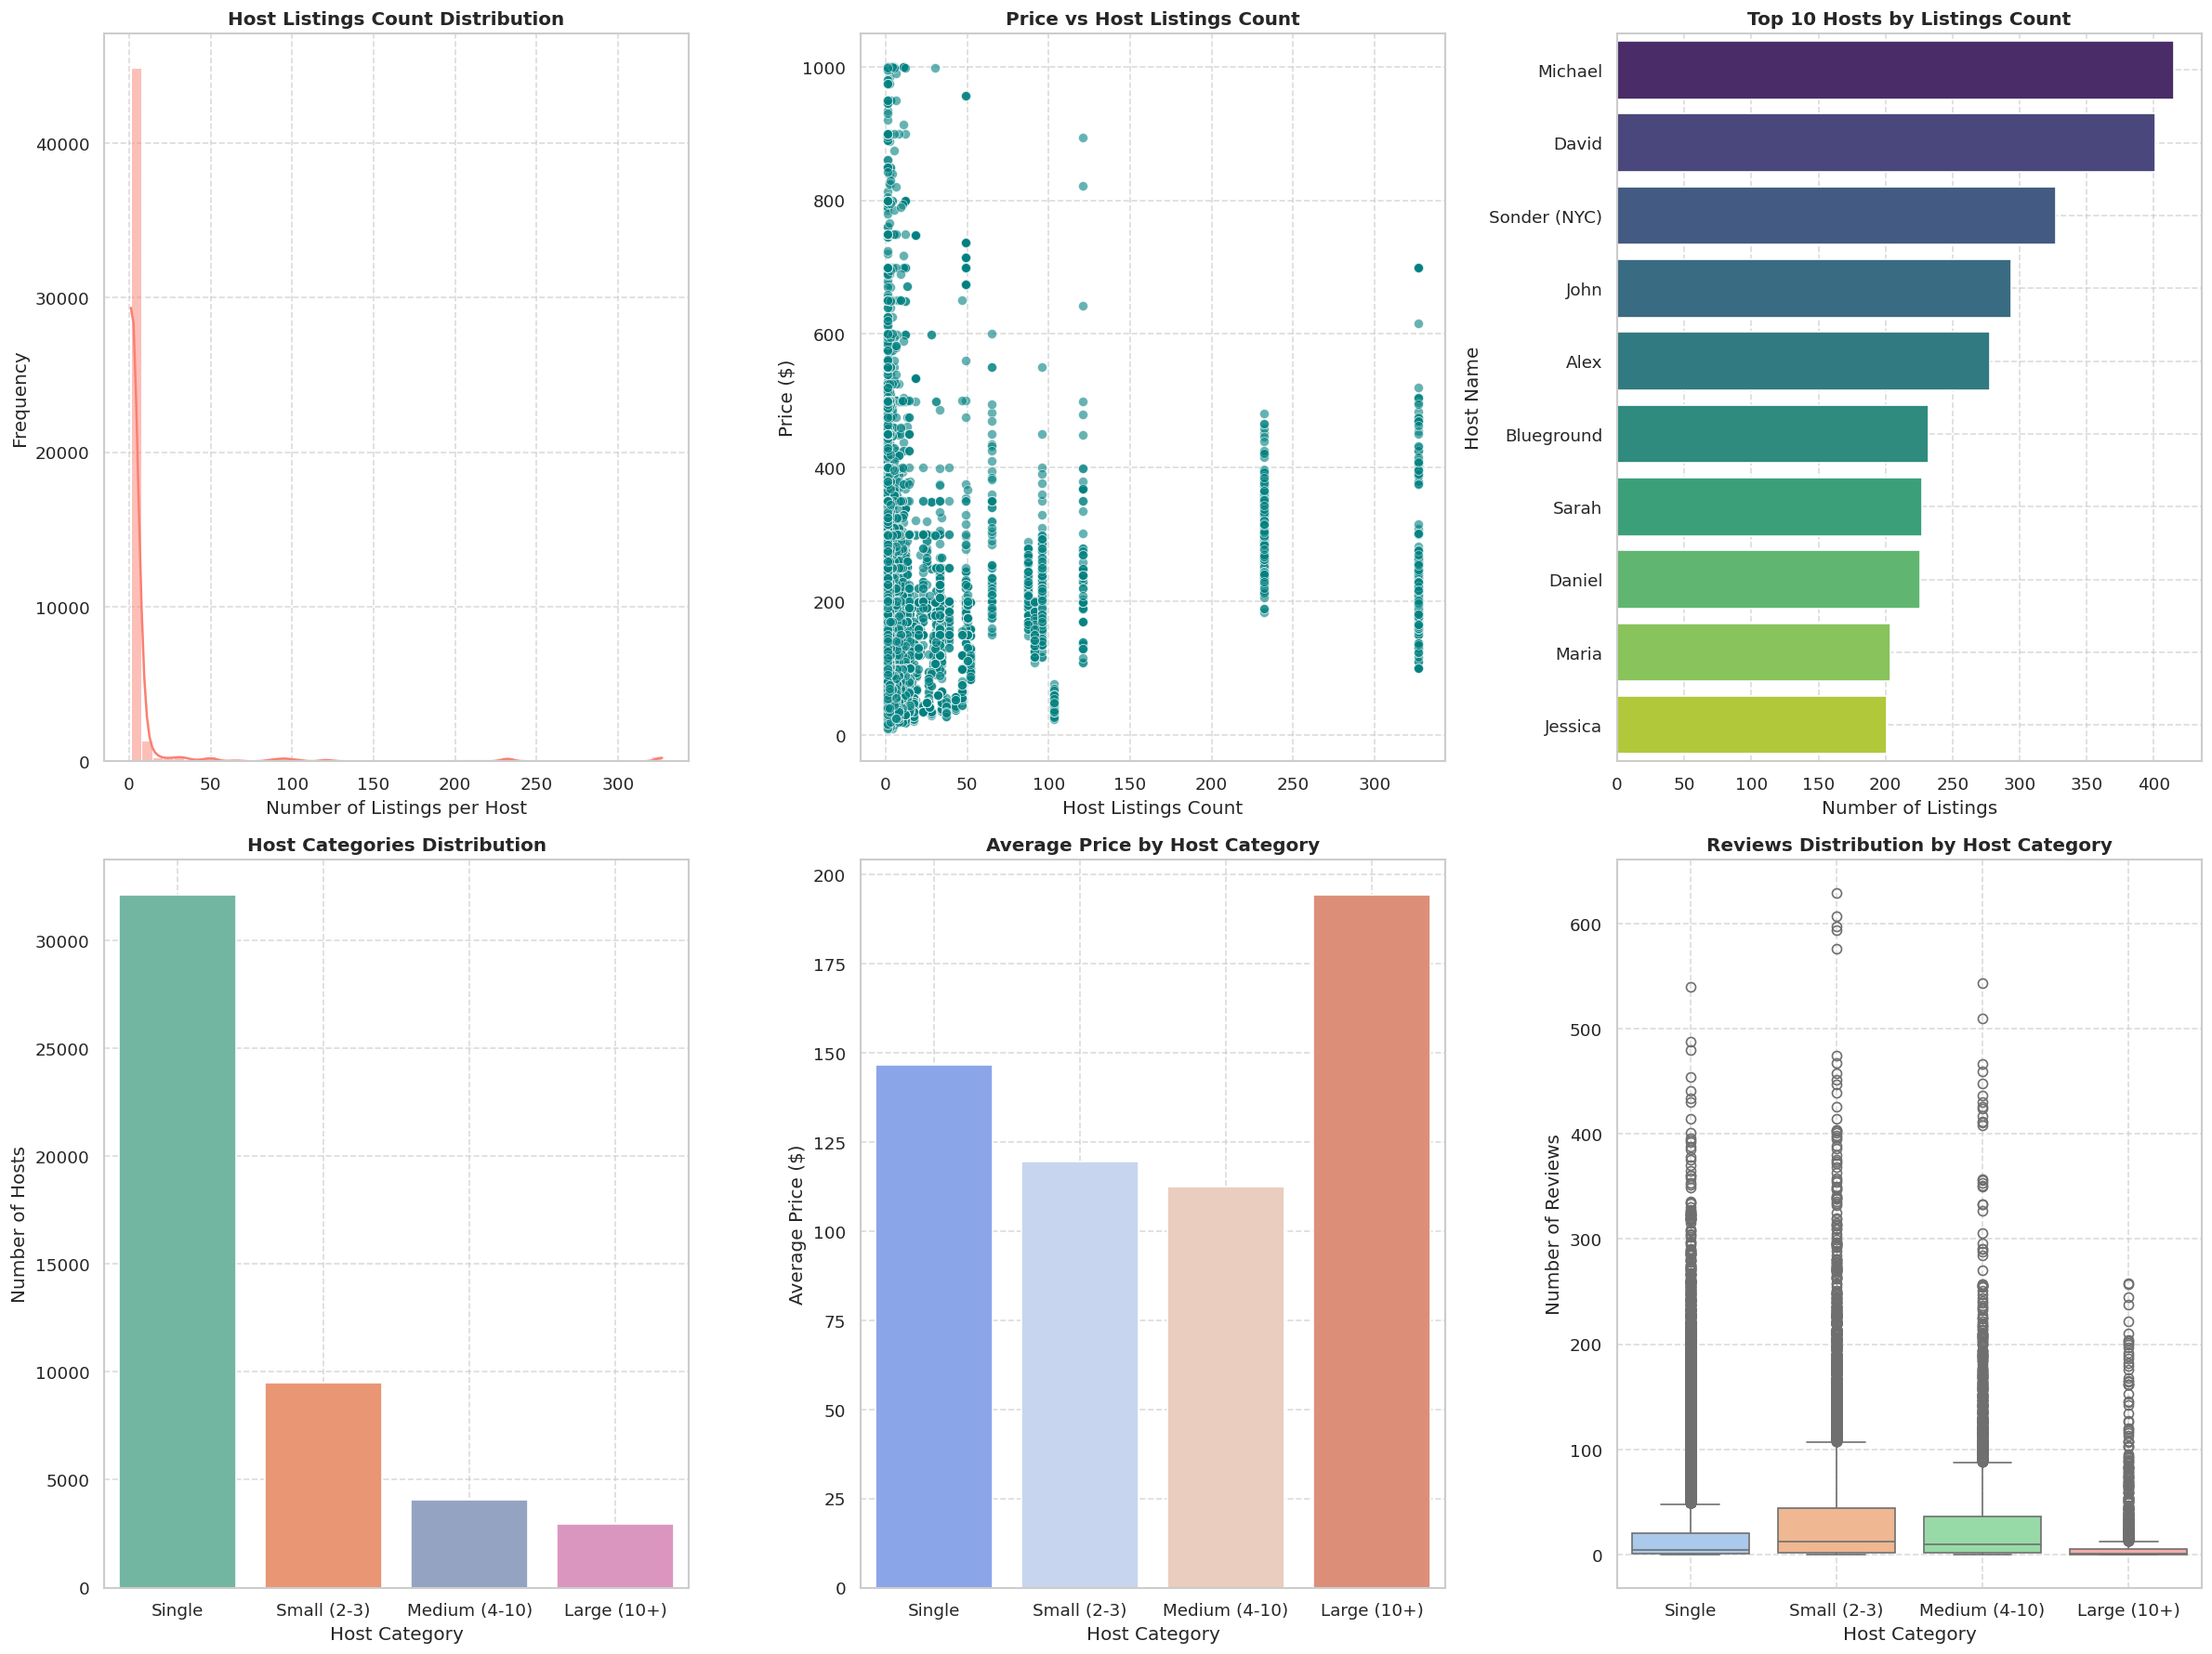

In [161]:
plt.figure(figsize=(20, 15))

# Host listings distribution
plt.subplot(2, 3, 1)
sns.histplot(data=df, x='calculated_host_listings_count', bins=50, kde=True, color='salmon')
plt.title('Host Listings Count Distribution', fontweight='bold')
plt.xlabel('Number of Listings per Host')
plt.ylabel('Frequency')
plt.grid(linestyle='--',alpha=0.7)

# Price vs Host Listings Count
plt.subplot(2, 3, 2)
sns.scatterplot(data=df, x='calculated_host_listings_count', y='price', alpha=0.6, color='teal')
plt.title('Price vs Host Listings Count', fontweight='bold')
plt.xlabel('Host Listings Count')
plt.ylabel('Price ($)')
plt.grid(linestyle='--',alpha=0.7)

# Top 10 Hosts by Number of Listings
plt.subplot(2, 3, 3)
top_hosts = df.groupby('host_name')['id'].count().sort_values(ascending=False).head(10)
sns.barplot(x=top_hosts.values, y=top_hosts.index, palette='viridis')
plt.title('Top 10 Hosts by Listings Count', fontweight='bold')
plt.xlabel('Number of Listings')
plt.ylabel('Host Name')
plt.grid(linestyle='--',alpha=0.7)

# Host Category Distribution
plt.subplot(2, 3, 4)
host_categories = pd.cut(df['calculated_host_listings_count'], bins=[0, 1, 3, 10, float('inf')],
                        labels=['Single', 'Small (2-3)', 'Medium (4-10)', 'Large (10+)'])
host_cat_counts = host_categories.value_counts().sort_index()
sns.barplot(x=host_cat_counts.index, y=host_cat_counts.values, palette='Set2')
plt.title('Host Categories Distribution', fontweight='bold')
plt.xlabel('Host Category')
plt.ylabel('Number of Hosts')
plt.grid(linestyle='--',alpha=0.7)

# Average Price by Host Category
plt.subplot(2, 3, 5)
df_temp = df.copy()
df_temp['host_category'] = host_categories
avg_price_by_host = df_temp.groupby('host_category')['price'].mean().sort_index()
sns.barplot(x=avg_price_by_host.index, y=avg_price_by_host.values, palette='coolwarm')
plt.title('Average Price by Host Category', fontweight='bold')
plt.xlabel('Host Category')
plt.ylabel('Average Price ($)')
plt.grid(linestyle='--',alpha=0.7)

# Reviews Distribution by Host Category
plt.subplot(2, 3, 6)
sns.boxplot(data=df_temp, x='host_category', y='number_of_reviews', palette='pastel')
plt.title('Reviews Distribution by Host Category', fontweight='bold')
plt.xlabel('Host Category')
plt.ylabel('Number of Reviews')
plt.grid(linestyle='--',alpha=0.7)

plt.tight_layout()
plt.show()

# **Review Analysis**

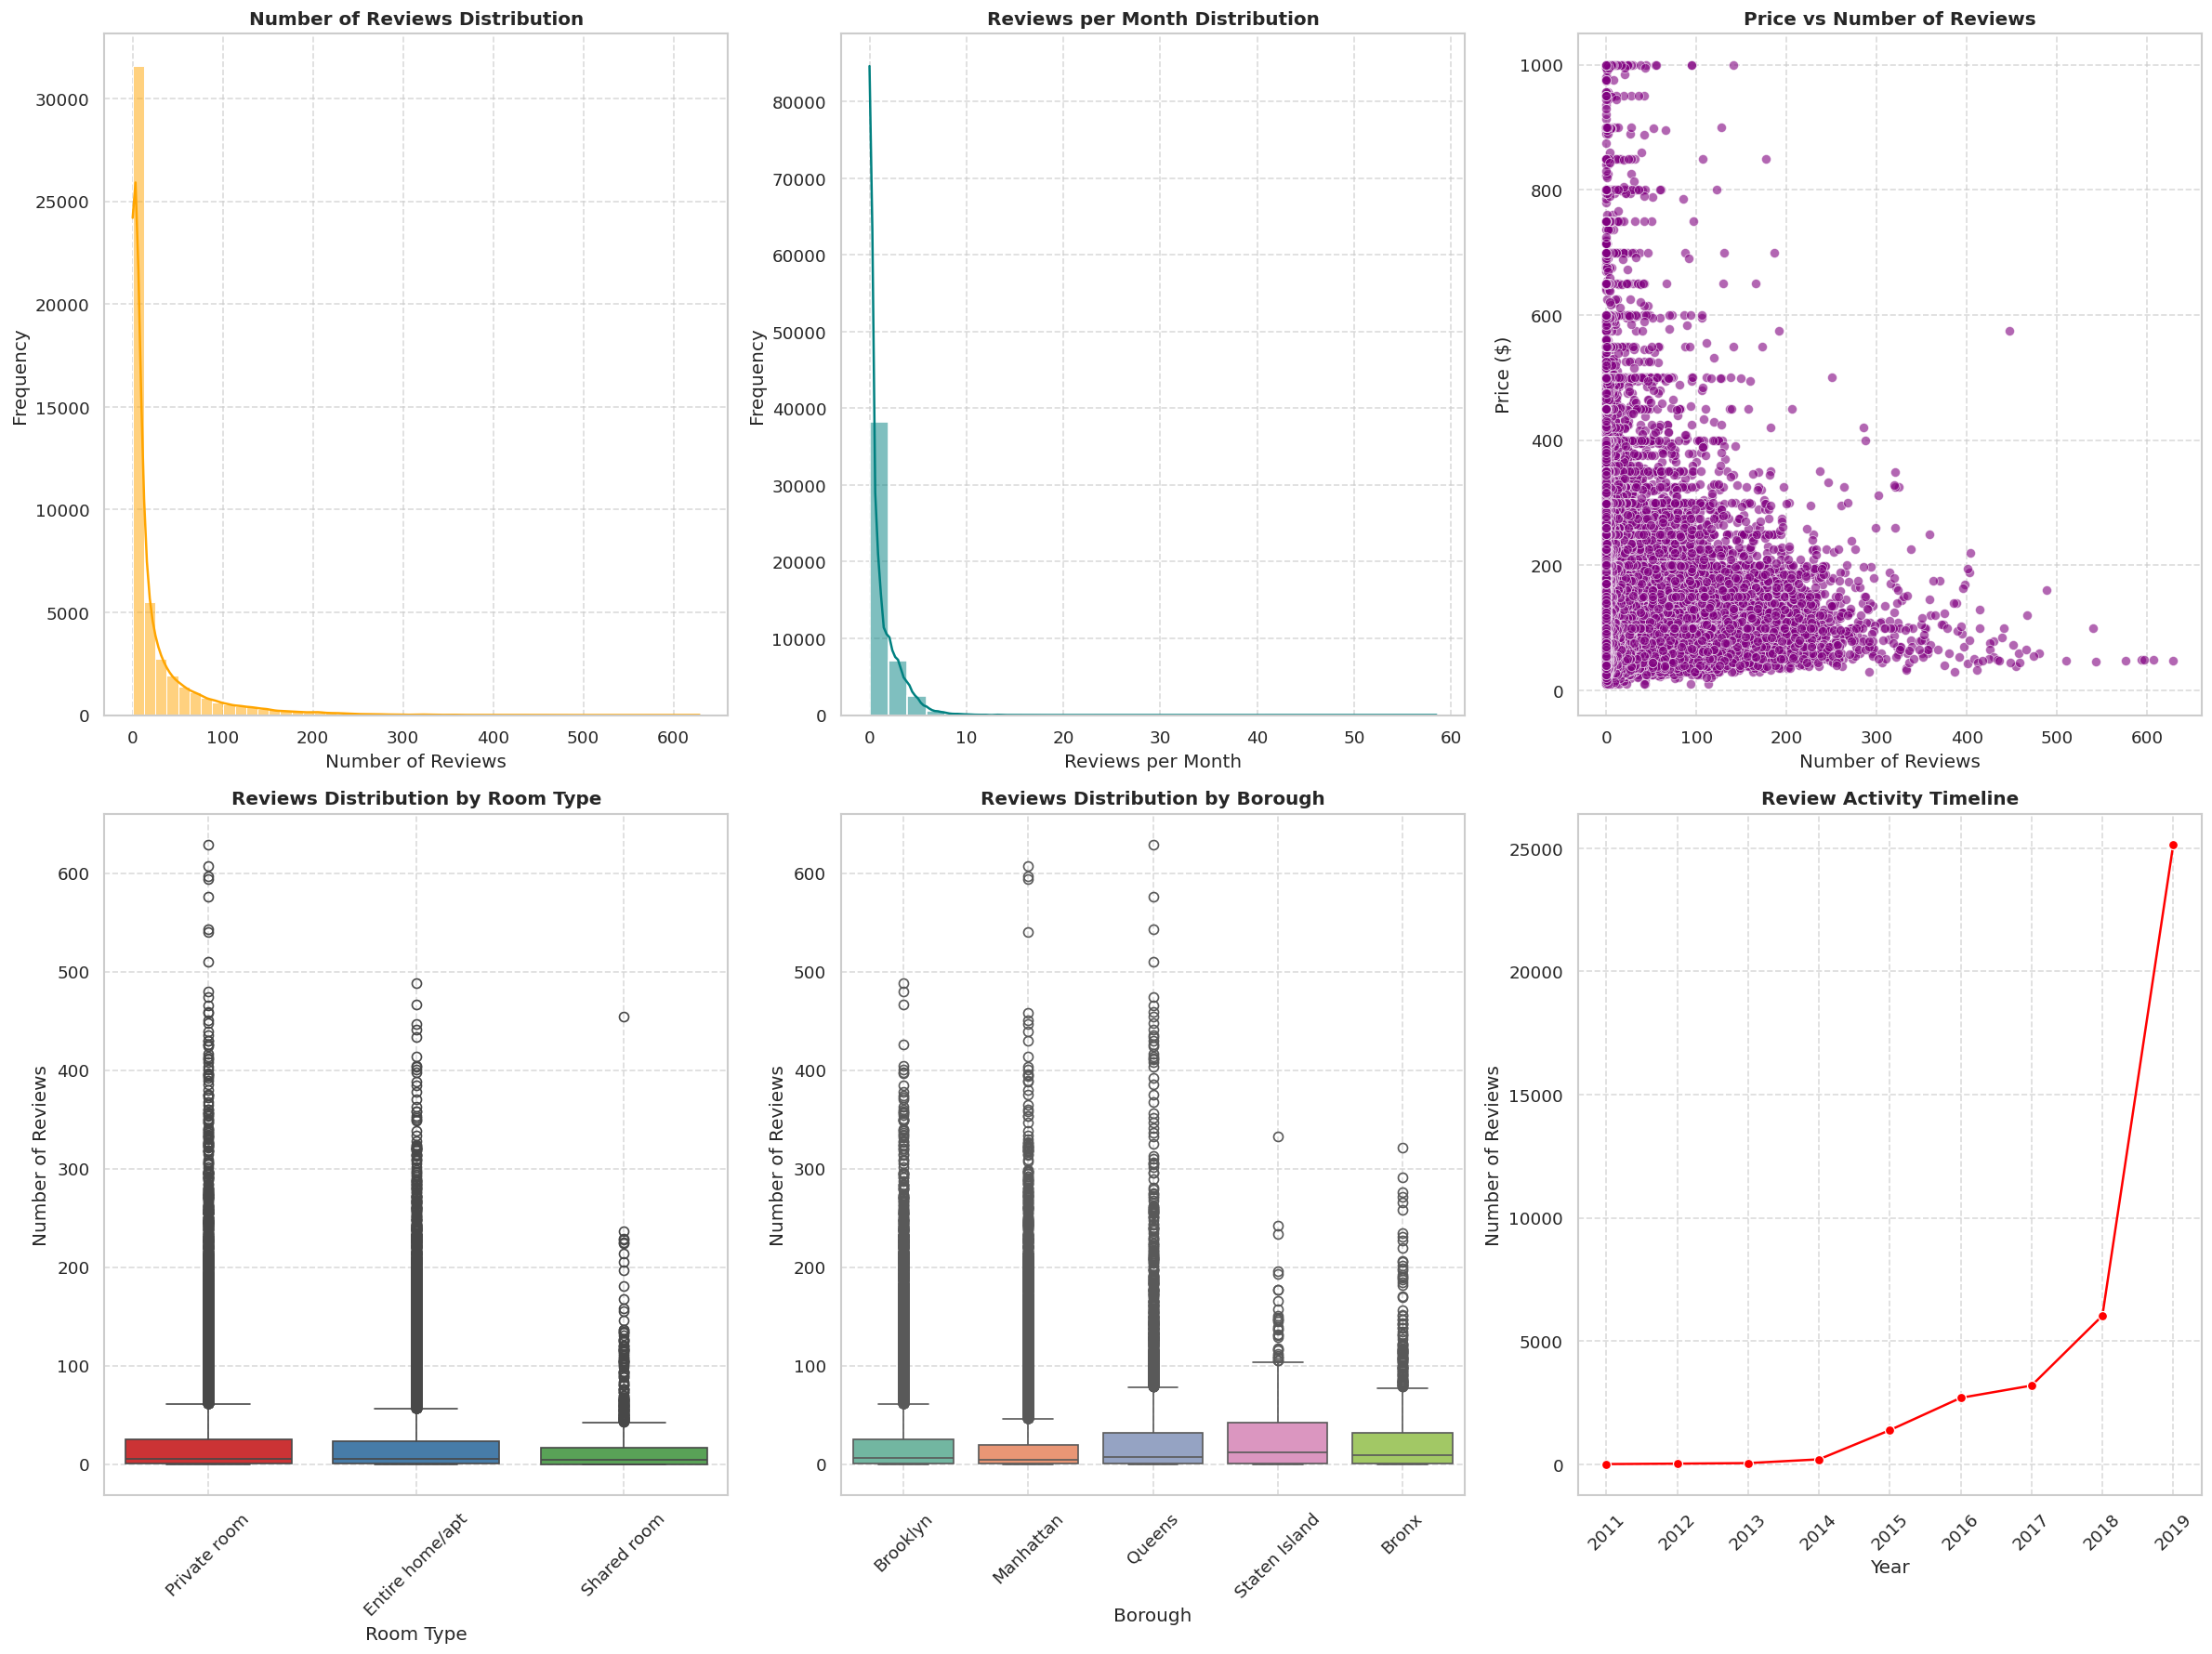

In [165]:
plt.figure(figsize=(20, 15))

# Number of Reviews Distribution
plt.subplot(2, 3, 1)
sns.histplot(data=df, x='number_of_reviews', bins=50, kde=True, color='orange')
plt.title('Number of Reviews Distribution', fontweight='bold')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.grid(linestyle='--',alpha=0.7)

# Reviews per Month Distribution (excluding NaNs)
plt.subplot(2, 3, 2)
sns.histplot(data=df.dropna(subset=['reviews_per_month']), x='reviews_per_month', bins=30, kde=True, color='teal')
plt.title('Reviews per Month Distribution', fontweight='bold')
plt.xlabel('Reviews per Month')
plt.ylabel('Frequency')
plt.grid(linestyle='--',alpha=0.7)

# Price vs Number of Reviews Scatterplot
plt.subplot(2, 3, 3)
sns.scatterplot(data=df, x='number_of_reviews', y='price', alpha=0.6, color='purple')
plt.title('Price vs Number of Reviews', fontweight='bold')
plt.xlabel('Number of Reviews')
plt.ylabel('Price ($)')
plt.grid(linestyle='--',alpha=0.7)

# Reviews Distribution by Room Type (boxplot)
plt.subplot(2, 3, 4)
sns.boxplot(data=df, x='room_type', y='number_of_reviews', palette='Set1')
plt.title('Reviews Distribution by Room Type', fontweight='bold')
plt.xlabel('Room Type')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(linestyle='--',alpha=0.7)

# Reviews Distribution by Borough (boxplot)
plt.subplot(2, 3, 5)
sns.boxplot(data=df, x='neighbourhood_group', y='number_of_reviews', palette='Set2')
plt.title('Reviews Distribution by Borough', fontweight='bold')
plt.xlabel('Borough')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(linestyle='--',alpha=0.7)

# Review Activity Timeline by Year
plt.subplot(2, 3, 6)
df_with_reviews = df.dropna(subset=['last_review']).copy()
if not df_with_reviews.empty:
    df_with_reviews['last_review_year'] = df_with_reviews['last_review'].dt.year
    review_timeline = df_with_reviews['last_review_year'].value_counts().sort_index()
    sns.lineplot(x=review_timeline.index, y=review_timeline.values, marker='o', color='red')
    plt.title('Review Activity Timeline', fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    plt.grid(linestyle='--',alpha=0.7)

plt.tight_layout()
plt.show()

# **Availability Analysis**

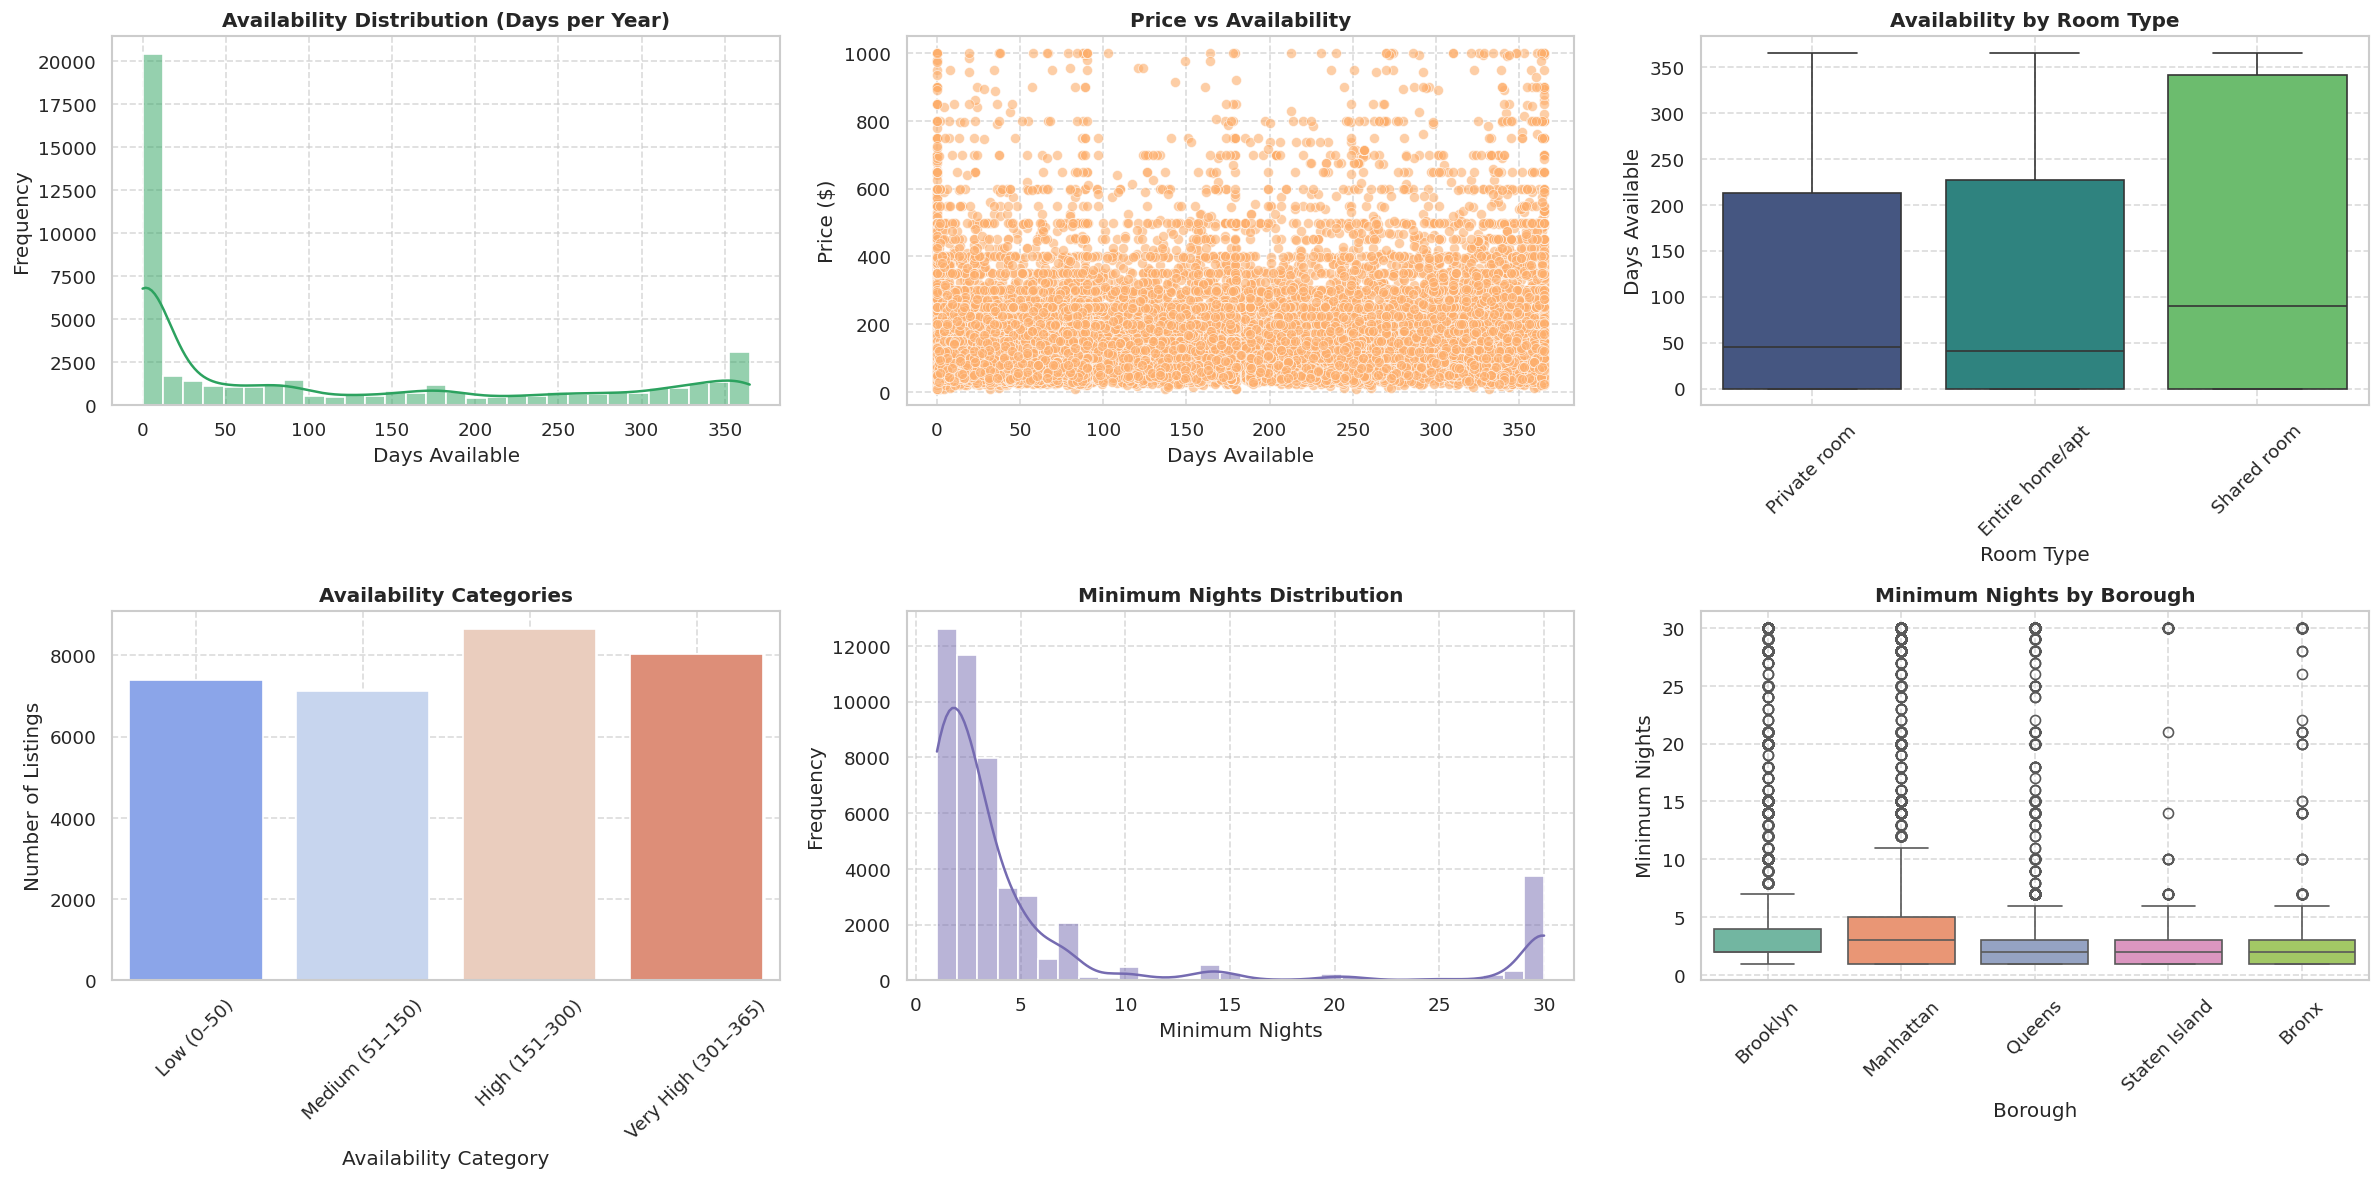

In [166]:
plt.figure(figsize=(20, 10))

# Availability distribution
plt.subplot(2, 3, 1)
sns.histplot(data=df, x='availability_365', bins=30, kde=True, color='#2ca25f')  # Green from Viridis
plt.title('Availability Distribution (Days per Year)', fontweight='bold')
plt.xlabel('Days Available')
plt.ylabel('Frequency')
plt.grid(linestyle='--',alpha=0.7)

# Price vs Availability
plt.subplot(2, 3, 2)
sns.scatterplot(data=df, x='availability_365', y='price', alpha=0.6, color='#fdae6b')  # Soft orange from Pastel
plt.title('Price vs Availability', fontweight='bold')
plt.xlabel('Days Available')
plt.ylabel('Price ($)')
plt.grid(linestyle='--',alpha=0.7)

# Availability by Room Type
plt.subplot(2, 3, 3)
sns.boxplot(data=df, x='room_type', y='availability_365', palette='viridis')  # Smooth Viridis palette
plt.title('Availability by Room Type', fontweight='bold')
plt.xlabel('Room Type')
plt.ylabel('Days Available')
plt.xticks(rotation=45)
plt.grid(linestyle='--',alpha=0.7)

# Availability Categories
plt.subplot(2, 3, 4)
availability_categories = pd.cut(
    df['availability_365'],
    bins=[0, 50, 150, 300, 365],
    labels=['Low (0–50)', 'Medium (51–150)', 'High (151–300)', 'Very High (301–365)']
)
avail_counts = availability_categories.value_counts().sort_index()
sns.barplot(x=avail_counts.index, y=avail_counts.values, palette='coolwarm')
plt.title('Availability Categories', fontweight='bold')
plt.xlabel('Availability Category')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.grid(linestyle='--',alpha=0.7)

#  Minimum Nights Distribution
plt.subplot(2, 3, 5)
sns.histplot(data=df[df['minimum_nights'] <= 30], x='minimum_nights', bins=30, kde=True, color='#756bb1')  # Purple from ColorBrewer
plt.title('Minimum Nights Distribution', fontweight='bold')
plt.xlabel('Minimum Nights')
plt.ylabel('Frequency')
plt.grid(linestyle='--',alpha=0.7)

# Minimum Nights by Borough
plt.subplot(2, 3, 6)
sns.boxplot(data=df[df['minimum_nights'] <= 30], x='neighbourhood_group', y='minimum_nights', palette='Set2')
plt.title('Minimum Nights by Borough', fontweight='bold')
plt.xlabel('Borough')
plt.ylabel('Minimum Nights')
plt.xticks(rotation=45)
plt.grid(linestyle='--',alpha=0.7)

plt.tight_layout()
plt.show()

# **Correlation Analysis**

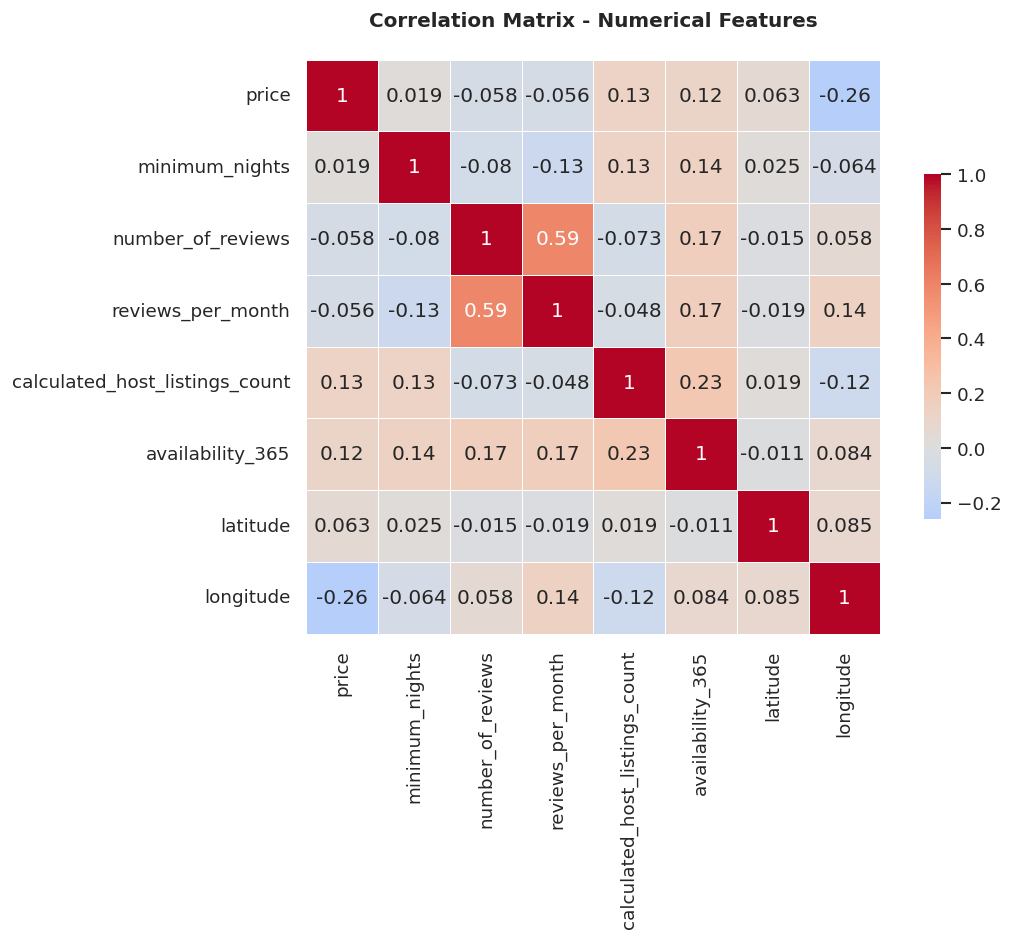

In [170]:
numerical_cols = ['price', 'minimum_nights', 'number_of_reviews',
                  'reviews_per_month', 'calculated_host_listings_count',
                  'availability_365', 'latitude', 'longitude']

corr_matrix = df[numerical_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.6})
plt.title('Correlation Matrix - Numerical Features', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# **Statistical Testing**

In [189]:
# ANOVA: Is Price Different Across Room Types?
from scipy.stats import f_oneway

room_groups = [group['price'] for _, group in df.groupby('room_type')]
anova_result = f_oneway(*room_groups)

print("\n ANOVA test: Price by Room Type")
print(f"  F-statistic = {anova_result.statistic:.2f}, p-value = {anova_result.pvalue:.4f}")
if anova_result.pvalue < 0.05:
    print("  Result: Significant difference in average price across room types.")
else:
    print("  Result: No significant difference in average price across room types.")


 ANOVA test: Price by Room Type
  F-statistic = 7056.14, p-value = 0.0000
  Result: Significant difference in average price across room types.


**Result Interpretation:**

The test reveals a strong difference in average prices across room types. With a p-value effectively zero, we can conclude that listing prices vary significantly based on room type.

In [184]:
# ANOVA: Does Availability Differ by Borough?
borough_groups = [group['availability_365'] for _, group in df.groupby('neighbourhood_group')]
availability_anova = f_oneway(*borough_groups)

print("\n ANOVA test: Availability by Borough")
print(f"  F-statistic = {availability_anova.statistic:.2f}, p-value = {availability_anova.pvalue:.4f}")
if availability_anova.pvalue < 0.05:
    print("  Result: Significant difference in availability across boroughs.")
else:
    print("  Result: No significant difference in availability across boroughs.")


 ANOVA test: Availability by Borough
  F-statistic = 217.63, p-value = 0.0000
  Result: Significant difference in availability across boroughs.


**Result Interpretation:**

The ANOVA test indicates a significant difference in availability across boroughs. Since the p-value is effectively zero, we can confidently say that the number of days listings are available varies notably depending on the borough.

In [182]:
# Chi-squared test: Is Room Type Related to High Availability?

from scipy.stats import chi2_contingency

df['high_avail'] = df['availability_365'] > 300
contingency = pd.crosstab(df['room_type'], df['high_avail'])
chi2, p, _, _ = chi2_contingency(contingency)

print("\nChi-Squared test: Room Type vs. High Availability")
print(f"  Chi2 = {chi2:.2f}, p-value = {p:.4f}")
if p < 0.05:
    print("  Result: Significant association between room type and high availability.")
else:
    print("  Result: No significant association between room type and high availability.")


Chi-Squared test: Room Type vs. High Availability
  Chi2 = 339.69, p-value = 0.0000
  Result: Significant association between room type and high availability.


**Result Interpretation:**

The Chi-Squared test shows a significant association between room type and high availability. With a p-value near zero, we can confidently conclude that the likelihood of having high availability depends on the room type.

# **Key insights**

In [197]:
print("🎯 Key Business Insights")
print("*" * 50)

# 💰 Pricing Insights
median_price = df['price'].median()
price_by_borough = df.groupby('neighbourhood_group')['price'].mean()
print(f"\n💰 PRICING")
print(f"• Median price: ${median_price:.2f}")
print(f"• Most expensive borough: {price_by_borough.idxmax()} (${price_by_borough.max():.2f})")
print(f"• Most affordable borough: {price_by_borough.idxmin()} (${price_by_borough.min():.2f})")

# 🏠 Room Type Insights
room_counts = df['room_type'].value_counts(normalize=True) * 100
print(f"\n🏠 ROOM TYPE")
print(f"• Most popular: {room_counts.idxmax()} ({room_counts.max():.1f}%)")
for rt, pct in room_counts.items():
    print(f"  - {rt}: {pct:.1f}%")

# 👤 Host Insights
superhosts = df[df['calculated_host_listings_count'] >= 10]
print(f"\n👤 HOSTS")
print(f"• Superhosts (10+ listings): {len(superhosts):,} ({len(superhosts)/len(df)*100:.1f}%)")
print(f"• Avg. listings per host: {df['calculated_host_listings_count'].mean():.1f}")

# 🗺️ Geographic Insights
borough_counts = df['neighbourhood_group'].value_counts(normalize=True) * 100
print(f"\n🗺️ GEOGRAPHY")
print(f"• Most listings: {borough_counts.idxmax()} ({borough_counts.max():.1f}%)")
for borough, pct in borough_counts.items():
    print(f"  - {borough}: {pct:.1f}%")

# 📅 Availability
high_avail = df[df['availability_365'] > 300]
print(f"\n📅 AVAILABILITY")
print(f"• High availability (300+ days): {len(high_avail):,} ({len(high_avail)/len(df)*100:.1f}%)")
print(f"• Avg. availability: {df['availability_365'].mean():.0f} days  per year")

# 🛌 Minimum stay
print(f"\n🛌 MINIMUM STAY")
print(f"• Average minimum nights: {df['minimum_nights'].mean():.0f}")
print(f"• Listings requiring more than 30 nights: {(df['minimum_nights'] > 30).mean() * 100:.1f}%")

🎯 Key Business Insights
**************************************************

💰 PRICING
• Median price: $105.00
• Most expensive borough: Manhattan ($178.94)
• Most affordable borough: Bronx ($85.36)

🏠 ROOM TYPE
• Most popular: Entire home/apt (51.8%)
  - Entire home/apt: 51.8%
  - Private room: 45.8%
  - Shared room: 2.4%

👤 HOSTS
• Superhosts (10+ listings): 3,153 (6.5%)
• Avg. listings per host: 7.2

🗺️ GEOGRAPHY
• Most listings: Manhattan (44.2%)
  - Manhattan: 44.2%
  - Brooklyn: 41.2%
  - Queens: 11.6%
  - Bronx: 2.2%
  - Staten Island: 0.8%

📅 AVAILABILITY
• High availability (300+ days): 8,023 (16.5%)
• Avg. availability: 112 days  per year

🛌 MINIMUM STAY
• Average minimum nights: 7
• Listings requiring more than 30 nights: 1.5%
